## Imports and global settings

In [1]:
from __future__ import absolute_import, division, print_function

import os
import numpy as np
import datetime
from keras.models import Sequential, Model
from keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D, Dense
from keras.layers import Lambda, Dropout, Flatten, Input, BatchNormalization
from keras.optimizers import Adam, Nadam, Adamax, Adadelta, Adagrad, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.data_utils import get_file
from keras.callbacks import ModelCheckpoint
from keras.utils.np_utils import to_categorical

import utils
reload(utils)
from utils import plots, remove_chars_re, plot_files, load_array, save_array

from IPython.display import FileLink
from IPython.core.debugger import Tracer

%matplotlib inline

Using Theano backend.
Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [2]:
path = './'
batch_size = 64
image_size = (224, 224)
weights_file = 'vgg16.h5'  # 'checkpoint-14.2-15.4.18-00-0.0883.hdf5'

## Load the data

#### Create a keras data generator, that flows the images from the specified dir.

In [3]:
def get_batch(path, batch_size, shuffle=True, augument=False, class_mode='categorical'):
    if augument:
        data_generator = ImageDataGenerator(
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            zoom_range=0.2,
            shear_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        )
    else:
        data_generator = ImageDataGenerator()
    return data_generator.flow_from_directory(directory=path,
                                              batch_size=batch_size,
                                              target_size=image_size,
                                              shuffle=shuffle,
                                              class_mode=class_mode)

#### Load all sets.

In [ ]:
train = get_batch(os.path.join(path, 'train/'),
                  augument=True, batch_size=batch_size)
valid = get_batch(os.path.join(path, 'valid/'), batch_size=batch_size * 2)
test = get_batch(os.path.join(path, 'test/'),
                 batch_size=batch_size,
                 shuffle=False,
                 class_mode=None)

## Define the model.

Define a convolutional layer

In [4]:
def convolution(model, layers, filters):
    for layer_index in range(layers):
        model.add(ZeroPadding2D((1, 1)))
        model.add(Convolution2D(filters, 3, 3, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    return model

Preprocessing the image: Sub imagenet mean values; Flip channels from RGB to BGR.

In [5]:
def preprocess(image):
    # input is shaped (batch_size, channels, width, height)
    imagenet_means = np.asarray([123.68, 116.779, 103.939]).reshape([3, 1, 1])
    image -= imagenet_means
    # Flip the channels
    return image[:, ::-1, :, :]

Define the model, according to the VGG paper.

In [6]:
def vgg16_model():
    model = Sequential()
    model.add(Lambda(preprocess, input_shape=(3, 224, 224)))
    model = convolution(model, 2, 64)
    model = convolution(model, 2, 128)
    model = convolution(model, 3, 256)
    model = convolution(model, 3, 512)
    model = convolution(model, 3, 512)
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1000, activation='softmax'))
    return model

model = vgg16_model()

/home/ubuntu/anaconda2/lib/python2.7/site-packages/keras/layers/core.py:621: UserWarning: `output_shape` argument not specified for layer lambda_1 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 224, 224)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


Load the precomputed Imagenet weights.

In [7]:
def vgg_load_weights(model, weights_file='vgg16.h5'):
    # If file exists in current dir (keras get_file doesn't check current dir)
    if os.path.exists(weights_file):
        weights = weights_file
    else:
        # Get file uses downloaded weights (in keras cache)
        # or downloads them if not present.
        path = 'http://www.platform.ai/models/'
        weights_file = 'vgg16.h5'
        weights = get_file(weights_file, path + weights_file,
                           cache_subdir='models')
    model.load_weights(weights)
    return model

model = vgg_load_weights(
    model, weights_file=weights_file)

Finally, compile and the model is ready to use.

In [8]:
def model_compile(model, optimizer=None, learning_rate=None):
    if not optimizer:
        optimizer = Adam()
    if learning_rate:
        optimizer.lr.set_value(learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    return model

model = model_compile(model)

Decode the ids of the 1000 classes in the Imagenet competition for humans.

In [15]:
def setup_imagenet_id_to_class():
    path = 'http://www.platform.ai/models/'
    class_mappings_filename = 'imagenet_class_index.json'
    mappings_file = get_file(class_mappings_filename, path +
                             class_mappings_filename, cache_subdir='models')
    with open(mappings_file, 'r') as f:
        mappings = json.load(f)

    return mappings
# Read the mappings from class id to class name
mappings = setup_imagenet_id_to_class()


def imagenet_id_to_class(id):
    '''A convenience function to extract the class name
    '''
    return mappings[str(id)][1]

Predict some images

In [ ]:
batch = train.next()
images = batch[0][0:5]
predictions = model.predict(images)
predictions_class_ids = np.argmax(predictions, axis=1)
predicted_classes = [imagenet_id_to_class(id) for id in predictions_class_ids]
plots(images, titles=predicted_classes)

## Finetune the model

Pop the 1000 classes last layer off our model, and replace it with a 2 class (dog, cat).

In [ ]:
def vgg_finetune(model):
    # Freeze the original model
    for layer in model.layers:
        layer.trainable = False
    # Replace the last layer
    model.pop()
    model.add(Dense(2, activation='softmax'))
    model = model_compile(model)
    return model

model = vgg_finetune(model)

In [ ]:
# model.optimizer.lr.set_value(0.001)
model = model_compile(model, optimizer=RMSprop())  # Adadelta

In [82]:
def get_checkpoint(model_name, period=1):
    now = datetime.datetime.now()
    date_string = "{0}.{1}-{2}.{3}.{4}".format(
        now.day, now.month, now.hour, now.minute, now.second)
    filepath = (model_name + 'checkpoint-' + date_string +
                '-{epoch:02d}-{val_loss:.4f}.hdf5')
    return ModelCheckpoint(filepath, save_weights_only=True,
                           period=period, save_best_only=True)

In [ ]:
checkpoint = get_checkpoint('Vanilla-VGG16')
model.fit_generator(train, samples_per_epoch=train.nb_sample,
                    nb_epoch=1,
                    validation_data=valid, nb_val_samples=valid.nb_sample,
                    callbacks=[checkpoint])

## Finetuning with features (embeddings) 

### Setup extract features model

In [ ]:
# Review the model to pick a layer to extract features
model.summary()

In [18]:
# We chose the last conv layer (after max pooling)
features_layer = model.get_layer(name="flatten_1")
features_layer

In [ ]:
# Model to extract the features
features_extract_model = Model(input=model.input,
                               output=features_layer.output)

### Get features/embeddings

In [30]:
# Get train, valid and test data without augumentation
train = get_batch(os.path.join(path, 'train/'),
                  batch_size=batch_size,
                  augument=False,
                  shuffle=False,
                  )
train_labels = to_categorical(train.classes, nb_classes=train.nb_class)
train_filenames = train.filenames
valid = get_batch(os.path.join(path, 'valid/'),
                  batch_size=batch_size * 2,
                  augument=False,
                  shuffle=False
                  )
valid_labels = to_categorical(valid.classes, nb_classes=valid.nb_class)
valid_filenames = valid.filenames
test = get_batch(os.path.join(path, 'test/'),
                 batch_size=batch_size,
                 augument=False,
                 shuffle=False,
                 class_mode=None)
test_filenames = test.filenames

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


In [ ]:
# Sanity check some labels
start = 998
end = 1003
files = [os.path.join(path, 'valid/', filename)
         for filename in valid.filenames[start:end]]
plot_files(files, titles=valid.classes[start:end])

#### Validation set features

In [ ]:
# Extract the valid features
valid_features = features_extract_model.predict_generator(
    valid, val_samples=valid.nb_sample)
save_array('valid_features_vgg16.bc', valid_features)
save_array('valid_labels.bc', valid_labels)
save_array('valid_filenames.bc', valid_filenames)

In [11]:
# Load valid features (if we didnt just compute them)
valid_features = load_array('valid_features_vgg16.bc')
valid_labels = load_array('valid_labels.bc')
valid_filenames = load_array('valid_filenames.bc')
valid_features.shape, valid_labels.shape, valid_filenames.shape

((2000, 25088), (2000, 2))

#### Train set features

In [ ]:
# Extract the train features
train_features = features_extract_model.predict_generator(
    train, val_samples=train.nb_sample)
save_array('train_features_vgg16.bc', train_features)
save_array('train_labels.bc', train_labels)
save_array('train_filenames.bc', train_filenames)

In [12]:
# Load train features (if we didnt just compute them)
train_features = load_array('train_features_vgg16.bc')
train_labels = load_array('train_labels_vgg16.bc')
train_filenames = load_array('train_filenames.bc')
train_features.shape, train_labels.shape, train_filenames.shape

((23000, 25088), (23000, 2))

#### Test set features

In [ ]:
# Extract the test features
test_features = features_extract_model.predict_generator(
    test, val_samples=test.nb_sample)
save_array('test_features_vgg16.bc', test_features)
save_array('test_filenames.bc', test_filenames)

In [32]:
# Load test features (if we didnt just compute them)
test_features = load_array('test_features_vgg16.bc')
test_filenames = load_array('test_filenames.bc')
test_features.shape, test_filenames.shape

((12500, 25088), (12500,))

### Setup faster model that uses features, instead of images

In [ ]:
# To load the weights for the dense layers,
# we need to set the layers' names to be the same
# as in the saved weights file.

# Review the saved weights file
import h5py
# '/home/ubuntu/.keras/models/vgg16.h5'
weights_file = 'checkpoint-14.2-15.4.18-00-0.0883.hdf5'
f = h5py.File(weights_file, mode='r')
[n.decode('utf8') for n in f.attrs['layer_names']]

In [15]:
# Setup the faster model.
# Use the layer names from the saved weights file.


def setup_model_features(input_shape):
    model = Sequential()
    # init="he_normal",
    model.add(Dense(4096, activation='relu',
                    name='dense_1', input_shape=input_shape))
    model.add(Dropout(0.5))
    # init="he_normal",
    model.add(Dense(4096, activation='relu', name='dense_2'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax', name='dense_4'))
    return model

# (512, 7, 7)
model_fast = setup_model_features(input_shape=(25088,))
# Load the weights for current layers only. This works because we named
# them the same way as in the weights file.
# weights = get_file(weights_file, path + weights_file,
#                    cache_subdir='models')
model_fast.load_weights(weights_file, by_name=True)

In [17]:
model_fast.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_1 (Dense)                  (None, 4096)          102764544   dense_input_1[0][0]              
____________________________________________________________________________________________________
dropout_3 (Dropout)              (None, 4096)          0           dense_1[0][0]                    
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 4096)          16781312    dropout_3[0][0]                  
____________________________________________________________________________________________________
dropout_4 (Dropout)              (None, 4096)          0           dense_2[0][0]                    
___________________________________________________________________________________________

In [76]:
model_fast = model_compile(model_fast, learning_rate=0.000001)

In [ ]:
# Sanity check: Predict some classes
images = train_features[90:110]
predictions = model_fast.predict(images)
predictions_class_ids = np.argmax(predictions, axis=1)
# predicted_classes = [imagenet_id_to_class(id) for id in predictions_class_ids]
plot_files([os.path.join('./sample/train', filename) for filename in train.filenames[90:110]],
           titles=zip(predictions_class_ids, train_labels[90:110]),
           images_per_row=4)

In [80]:
checkpoint = get_checkpoint('VGG16-Features', period=5)
batch_size = 1024
model_fast.fit(train_features, train_labels,
               shuffle=True,
               nb_epoch=10,
               validation_data=(valid_features, valid_labels),
               batch_size=batch_size,
               callbacks=[checkpoint])

Train on 23000 samples, validate on 2000 samples
Epoch 1/10
23000/23000 [==============================] - 9s - loss: 0.0157 - acc: 0.9964 - val_loss: 0.0749 - val_acc: 0.9845

## Review Results

In [74]:
# # Get validation predictions
# valid = get_batch(os.path.join(path, 'valid/'),
#                   batch_size=batch_size * 2,
#                   shuffle=False,
#                   class_mode=None)
# val_results = model.predict_generator(valid, valid.nb_sample)

val_results = model_fast.predict(valid_features, batch_size=1024)

In [33]:
# cat_prob = val_results[:,0]
probabilities = val_results[:, 1]
filenames = np.array([os.path.join(path, 'valid', filename)
                      for filename in valid_filenames])

classes = valid.classes
results = np.stack([probabilities,
                    filenames,
                    classes])
# How many images can we display at once
max_images = 4

#### Correct labels at random

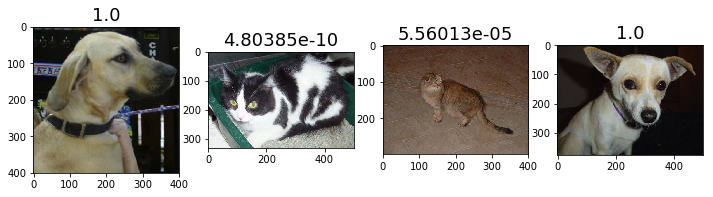

In [34]:
corrects = np.where(np.round(probabilities) == classes)[0]
random_correct_indexes = np.random.permutation(corrects)[0:max_images]
plot_files(filenames[random_correct_indexes],
           titles=probabilities[random_correct_indexes])

#### Incorrect labels at random

In [ ]:
# Since they are a small amount we will display them all
incorrects = np.where(np.round(probabilities) != classes)[0]
# random_incorrect_indexes = np.random.permutation(incorrects)[0:max_images]
# display all image in the incorrect index, max_images at a time
plot_files(filenames[incorrects],
           titles=probabilities[incorrects],
           images_per_row=max_images)


#### The most correct labels of each class (high prob and correct)


##### Correct cats

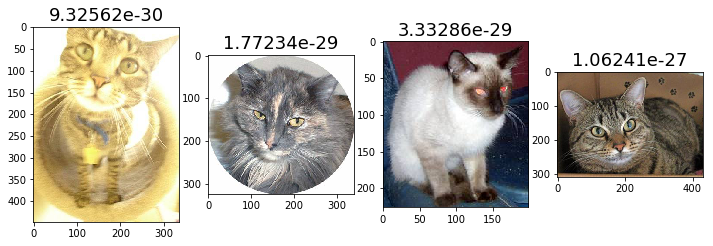

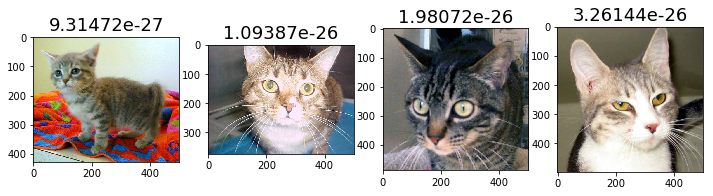

In [62]:
correct_cat_ids = np.where(
    (np.round(probabilities) == 0))[0]
# Indexes to sort correct)cat_ids
sort_indexes = np.argsort(probabilities[correct_cat_ids])
# Sorted correct
most_correct_cats = correct_cat_ids[sort_indexes]
# Get only a few samples
most_correct_cats = most_correct_cats[0:(max_images * 2)]
plot_files(filenames[most_correct_cats],
           images_per_row=max_images,
           titles=probabilities[most_correct_cats])

##### Correct dogs

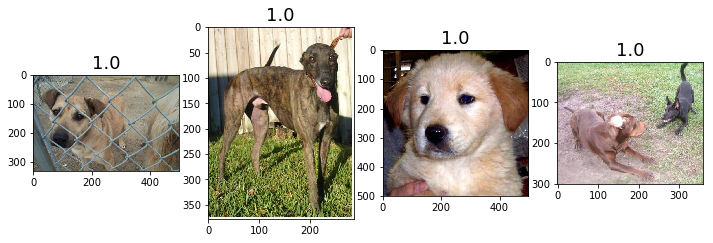

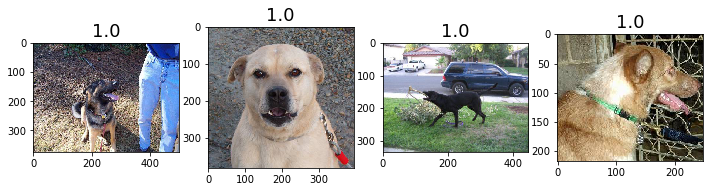

In [63]:
# Get correct dog predictions
correct_dog_ids = np.where(np.round(probabilities) == 1)[0]
# Get ids to sort correct dogs
sort_ids = np.argsort(probabilities[correct_dog_ids])
# Reverse the sort so we get the most correct
sort_ids = sort_ids[::-1]
# Sort correct dog ids
most_correct_dogs = correct_dog_ids[sort_ids]
# Get only the most correct ones
most_correct_dogs = most_correct_dogs[0:max_images * 2]
plot_files(filenames[most_correct_dogs], titles=probabilities[
           most_correct_dogs], images_per_row=max_images)

#### The most incorrect labels of each class (high prob, but incorrect)


##### Incorrect dogs

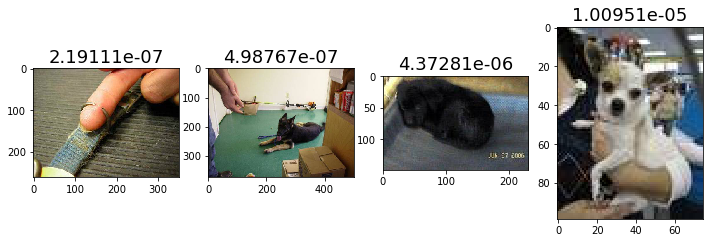

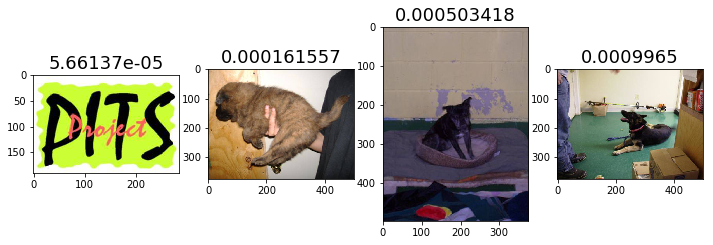

In [69]:
# Get indexes where both class is dog and we were off
incorrect_dogs = np.where(
    (classes == 1) & (np.round(probabilities) != classes))[0]
# Returns the indexes that would sort the array
sort_indexes = np.argsort(probabilities[incorrect_dogs])
# Apply the sort indexes to the incorrect dogs indexes
sorted_incorrect_dogs = incorrect_dogs[sort_indexes]
# Select only the most incorrect dogs
sorted_incorrect_dogs = sorted_incorrect_dogs[:max_images * 2]
plot_files(filenames[sorted_incorrect_dogs],
           titles=probabilities[sorted_incorrect_dogs],
           images_per_row=max_images)

##### Incorrect cats

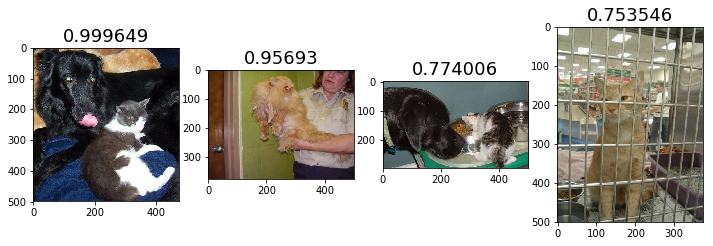

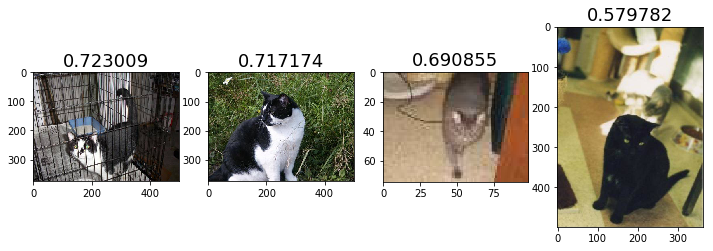

In [70]:
# Get indexes where both class is cat and we were off
incorrect_cats = np.where(
    (classes == 0) & (np.round(probabilities) != classes))[0]
# Get the indexes that would sort the probabilities array
sort_indexes = np.argsort(probabilities[incorrect_cats])
# Reverse sort indexes, because we want low probabilities, not high
sort_indexes = sort_indexes[::-1]
# Use the sort indexes to sort the incorrect cat indexes
incorrect_cats_sorted = incorrect_cats[sort_indexes]
# Use only the most incorrect cats
incorrect_cats_sorted = incorrect_cats_sorted[:max_images * 2]
plot_files(filenames[incorrect_cats_sorted],
           titles=probabilities[incorrect_cats_sorted],
           images_per_row=max_images)

#### The most uncertian labels (probability close to 0.5)

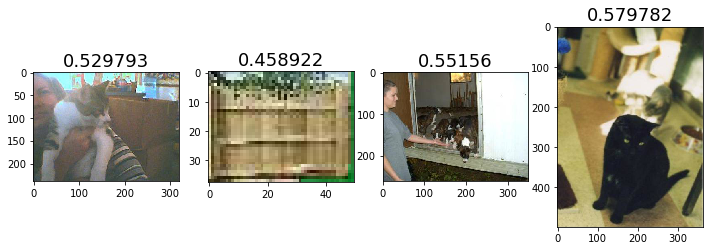

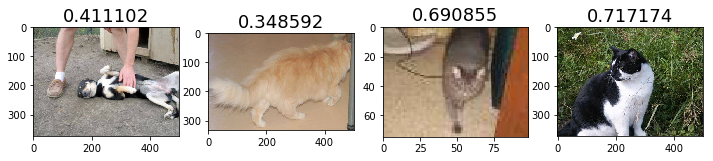

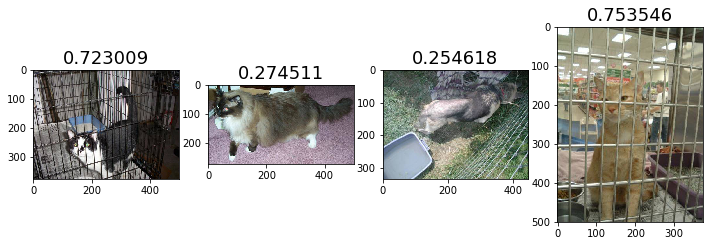

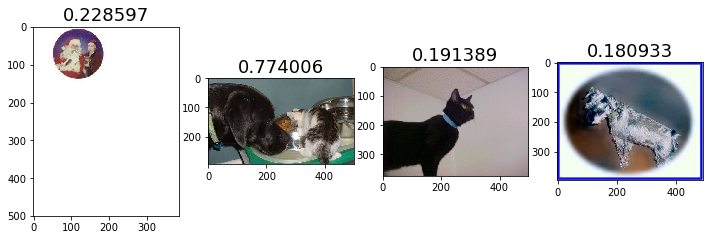

In [73]:
# Get distance to 0.5 (most uncertain)
most_uncertain = np.abs(probabilities - 0.5)
# Sort by distance to 0.5 (most uncertain)
sort_indexes = np.argsort(most_uncertain)
# Get only the most uncertain
sort_indexes = sort_indexes[:max_images * 4]
plot_files(filenames[sort_indexes],
           titles=probabilities[sort_indexes],
           images_per_row=max_images)

## Submit results

#### Prepare predictions for test set


In [84]:
# test_predictions = model.predict_generator(test, val_samples=test.nb_sample)
test_predictions = model_fast.predict(test_features, batch_size=batch_size)

In [94]:
# get path to test files
test_filepaths = test_filenames


def filter_test_filepath(filepath):
    '''Utility func to transform 'test/1032.jpg' to 1032
    '''
    filepath = remove_chars_re(filepath, 'test/')
    return int(remove_chars_re(filepath, '.jpg'))
# Format test files as ids
test_ids = [filter_test_filepath(filepath)
            for filepath in test_filepaths]

In [96]:
# Get dog predictions only
dog_predictions = test_predictions[:, 1]

In [97]:
# Trim the predictions, so that we are not penalized for confident mistakes
predictions_trim = np.clip(dog_predictions, 0.02, 0.98)

In [98]:
predictions = np.stack([test_ids, predictions_trim], axis=1)

In [99]:
predictions[1:10, 1]

array([ 0.98,  0.02,  0.02,  0.02,  0.98,  0.02,  0.02,  0.02,  0.98])

#### Sanity check the results


In [ ]:
test = get_batch(os.path.join(path, 'test/'),
                 batch_size=batch_size,
                 shuffle=False,
                 class_mode=None)
test_batch = test.next()
start = 0

Found 12500 images belonging to 1 classes.


In [92]:
test_batch.shape

(1024, 3, 224, 224)

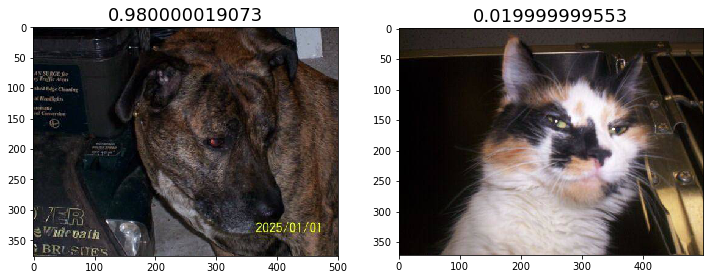

In [113]:
start = start + 2
end = start + 2
full_paths = [os.path.join('test', filename) for filename in test_filenames]
plot_files(full_paths[start:end], titles=predictions[start:end, 1])

#### Export the predictions to csv with Pandas.

In [114]:
import pandas as pd
now = datetime.datetime.now()
date_string = "{0}.{1}-{2}.{3}.{4}".format(
    now.day, now.month, now.hour, now.minute, now.second)
filename = ("cats_dogs-{0}.csv".format(date_string))
header = ['id', 'label']
df = pd.DataFrame(predictions)
# Convert ids (first column) to int
df[0] = df[0].astype(int)
df.to_csv(filename, header=header, index=False)
FileLink(filename)

/home/ubuntu/mount/course/cats-dogs/cats_dogs-17.2-10.40.43.csv

#### Submit to kaggle

In [116]:
!kg submit -c 'dogs-vs-cats-redux-kernels-edition' -m "$date_string" $filename